In [2]:
!pip install --upgrade --force-reinstall numpy matplotlib torch pandas pykan jax scikit-learn polars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 752.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Solving Example 1...
checkpoint directory created: ./model
saving model version 0.0
Step 1/500, Loss: 6.3165e+00


/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

Step 51/500, Loss: 1.0032e-02
Step 101/500, Loss: 4.7061e-05
Step 151/500, Loss: 8.3052e-06
Step 201/500, Loss: 5.4678e-06
Step 251/500, Loss: 4.1958e-06
Step 301/500, Loss: 3.3603e-06
Step 351/500, Loss: 2.7478e-06
Step 401/500, Loss: 2.2761e-06
Step 451/500, Loss: 1.9050e-06
Step 500/500, Loss: 1.6159e-06
Plotting results...


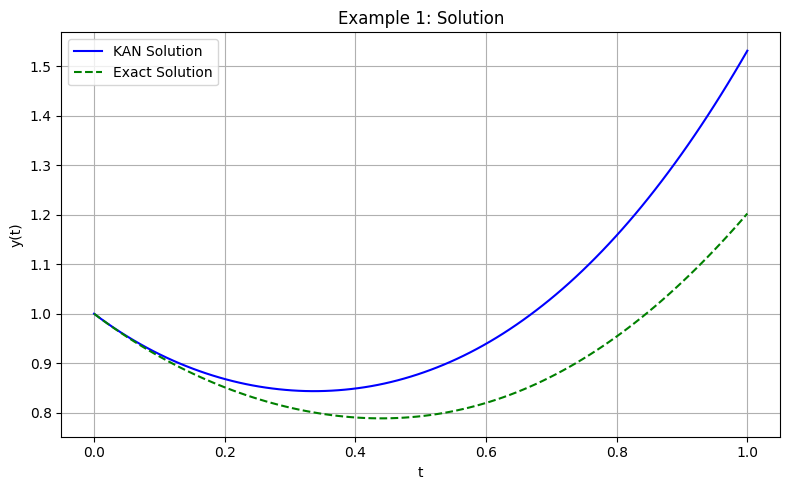

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import MultKAN

def solve_example1():
    """
    Solve the first ODE example with an improved setup.
    """
    # Create KAN model: 1D input (t), 1D output (y), 12 hidden neurons
    model = MultKAN(width=[1, 12, 1], grid=15, k=4, seed=42)

    # Define exact solution
    def exact_solution(t):
        return (np.exp(-t**2 / 2) + t**5 + t**3 + t**2) / (t**3 + t + 1)

    # Define the ODE and physics-informed loss
    def physics_loss(t, y):
        # Compute dy/dt using automatic differentiation
        t.requires_grad_(True)
        y_pred = model(t)
        dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

        # Define the ODE residual
        residual = dy_dt + ((1 + 3 * t**2) / (1 + t + t**3)) * y_pred - (2 * t + t**3 + t**2 * ((1 + 3 * t**2) / (1 + t + t**3)))
        return torch.mean(residual**2)

    # Training points
    t_train = torch.linspace(0, 1, 100).reshape(-1, 1)

    # Add boundary condition
    def boundary_loss():
        t_bc = torch.tensor([[0.0]])  # Boundary point
        y_bc = torch.tensor([[1.0]])  # Boundary condition: y(0) = 1
        y_pred = model(t_bc)
        return torch.mean((y_pred - y_bc)**2)

    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for step in range(500):  # Increase steps for better convergence
        optimizer.zero_grad()
        loss = physics_loss(t_train, model(t_train)) + boundary_loss()
        loss.backward()
        optimizer.step()

        # Print training progress every 50 steps
        if step % 50 == 0 or step == 499:
            print(f"Step {step+1}/500, Loss: {loss.item():.4e}")

    # Generate solution points for plotting
    t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_pred = model(t_eval).detach().numpy()
    y_exact = exact_solution(t_eval.numpy())

    return t_eval.numpy(), y_pred, y_exact

def plot_results(t1, y1, y1_exact):
    plt.figure(figsize=(8, 5))
    plt.plot(t1, y1, 'b-', label='KAN Solution')
    plt.plot(t1, y1_exact, 'g--', label='Exact Solution')
    plt.title('Example 1: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    print("Solving Example 1...")
    t1, y1, y1_exact = solve_example1()

    print("Plotting results...")
    plot_results(t1, y1, y1_exact)

if __name__ == "__main__":
    main()
